# Linear Regression Modeling

Aaron Balke

December 14th, 2023

# Part 1: Research Question

## Question

For this analysis, my research question is, "Does Total Charges correlate to any specific condition?".

## Analysis Goals

In most situations, but in healthcare particularly, the financial burden of products and services can be overwhelming and difficult to plan for. By finding a correlation between Total Charges and specific conditions, we will be able to provide cost estimations, relieving some financial uncertainty for our patients.

Using a multiple regression model to answer our research question will give our organization/hospital the ability to predict patient charges. This will allow us to make informed resource management decisions, to efficiently and effectively treat patients, and give the patients the ability to plan and estimate financially.

# Part 2: Method Justification

## Assumptions

1. Linear relationship: The independent and dependent variables have to have a relationship - without a relationship, there is no point in including the variable.

2. Residual Normality: The Variance of all data points is normally distributed.

3. No or little multicollinearity: Perfect Relationships between exploratory variables should be avoided. Multicollinearity leads to Type II errors (False Negatives) - we accept the Null Hypothesis when it should be rejected.

4. Independence: Each variable is independent of all other variables

(Statistics Solutions)

## Tool Benefits

Python is the chosen programming language. This is because it has:
1. Strong module/library support: For our analysis, we will need a method of calculating the variance inflation factor (VIF). By using Python, we can easily access the VIF method provided by the statsmodel library, this would not have been possible as simply in another language.
2. Integration with Jupyter Notebook: Python is the default language supported by Jupyter Notebook, giving us access to the features of Jupyter Notebook, particularly checkpoints, which are saved file states, giving us access to analysis states without rerunning intense calculations on every view. This will be handy when we are running OLS Regression, we will only want to run a model once, save its state, and then move to the next point - not rerun the model every time we want to move on.

## Technique Explanation

For our research questions, we need to model the relationships between a continuous dependent variable, the total amount charged, against continuous and categorical independent variables - which Multiple Linear Regression is used for. The total charges are provided as a float point number, not discrete, making it work as our dependent variable for analysis.

# Part III: Data Preparation

## Data Cleaning

The main goal of this data cleaning is to remove all unnecessary information from the dataset. Since we are only comparing total charges to specific conditions, location data, and survey data will not be needed. Additionally, we will run duplicate checks, and missing value checks, then delete all records that are duplicates or missing values.

Steps:
1. Remove Duplicates
2. Handle Missing Values
3. Remove Usused Features

In [1]:
# Standard Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels imports for Multiple Regression Model and Evaluation Methods
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import Data
df = pd.read_csv('./medical_clean.csv')

In [2]:
# Get Shape of new dataframe of only duplicate values
df[df.duplicated()].shape

(0, 50)

In [3]:
# Aggregate NaN Values, filter aggregates > 0, returns # records with NaN values
nullity = df.isna().sum()
nullity[~(nullity == 0)].shape

(0,)

In [4]:
# Remove Unused Features
df.drop(
    columns=['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Zip', 'Lat', 'Lng', 'Area',
             'Population', 'TimeZone', 'Job', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'],
    inplace=True)

## Summary Statistics

Summary Statistics are split into 3 sections: The Dependent Variable, The Continuous Independent Variables, and The Categorical/Qualitative Independent Variables. This is done since they each have their descriptive methods.

In [5]:
# Get Summary Stats of Dependent Variable
df['TotalCharge'].describe()

count    10000.000000
mean      5312.172769
std       2180.393838
min       1938.312067
25%       3179.374015
50%       5213.952000
75%       7459.699750
max       9180.728000
Name: TotalCharge, dtype: float64

In [6]:
# Get Summary Stats of Continuous Independent Variables

features_continuous = ["Children", "Age", "Income", "VitD_levels", "Doc_visits", "Full_meals_eaten", "vitD_supp", "Initial_days",
    "Additional_charges"]

df[features_continuous].describe()

,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,Additional_charges
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.097200,53.511700,40490.495160,17.964262,5.012200,1.001400,0.398900,34.455299,12934.528587
std,2.163659,20.638538,28521.153293,2.017231,1.045734,1.008117,0.628505,26.309341,6542.601544
min,0.000000,18.000000,154.080000,9.806483,1.000000,0.000000,0.000000,1.001981,3125.703000
25%,0.000000,36.000000,19598.775000,16.626439,4.000000,0.000000,0.000000,7.896215,7986.487755
50%,1.000000,53.000000,33768.420000,17.951122,5.000000,1.000000,0.000000,35.836244,11573.977735
75%,3.000000,71.000000,54296.402500,19.347963,6.000000,2.000000,1.000000,61.161020,15626.490000
max,10.000000,89.000000,207249.100000,26.394449,9.000000,7.000000,5.000000,71.981490,30566.070000


In [7]:
# Get Summary Stats of Qualitative Independent Variables
features_categorical = ['Marital', 'Gender', 'ReAdmis', 'Soft_drink', 'Initial_admin', 'Overweight', 'HighBlood',
                        'Stroke', 'Complication_risk', 'Arthritis', 'Diabetes', 'Hyperlipidemia',
                        'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis',
                        'Asthma', 'Services']

for column in features_categorical:
    print(f"{df[column].name} Unique Values:")    
    print(f"{df[column].value_counts()}\n")

Marital Unique Values:
Widowed          2045
Married          2023
Separated        1987
Never Married    1984
Divorced         1961
Name: Marital, dtype: int64

Gender Unique Values:
Female       5018
Male         4768
Nonbinary     214
Name: Gender, dtype: int64

ReAdmis Unique Values:
No     6331
Yes    3669
Name: ReAdmis, dtype: int64

Soft_drink Unique Values:
No     7425
Yes    2575
Name: Soft_drink, dtype: int64

Initial_admin Unique Values:
Emergency Admission      5060
Elective Admission       2504
Observation Admission    2436
Name: Initial_admin, dtype: int64

Overweight Unique Values:
Yes    7094
No     2906
Name: Overweight, dtype: int64

HighBlood Unique Values:
No     5910
Yes    4090
Name: HighBlood, dtype: int64

Stroke Unique Values:
No     8007
Yes    1993
Name: Stroke, dtype: int64

Complication_risk Unique Values:
Medium    4517
High      3358
Low       2125
Name: Complication_risk, dtype: int64

Arthritis Unique Values:
No     6426
Yes    3574
Name: Arthritis, dty

## Distribution Visualizations
### Univariate Distributions

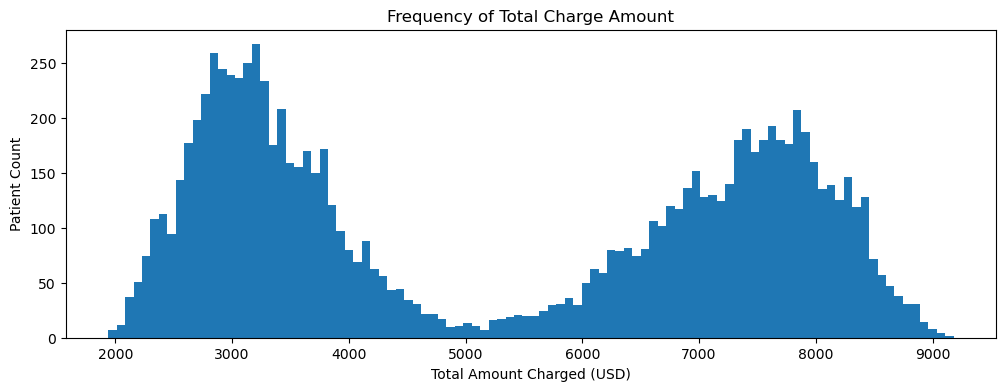

In [8]:
# Dependent Variable (TotalCharge) Visualization
plt.figure(figsize=(12,4))
plt.hist(data=df, x = "TotalCharge", bins=100)
plt.xlabel("Total Amount Charged (USD)")
plt.ylabel("Patient Count");
plt.title("Frequency of Total Charge Amount")
plt.show()

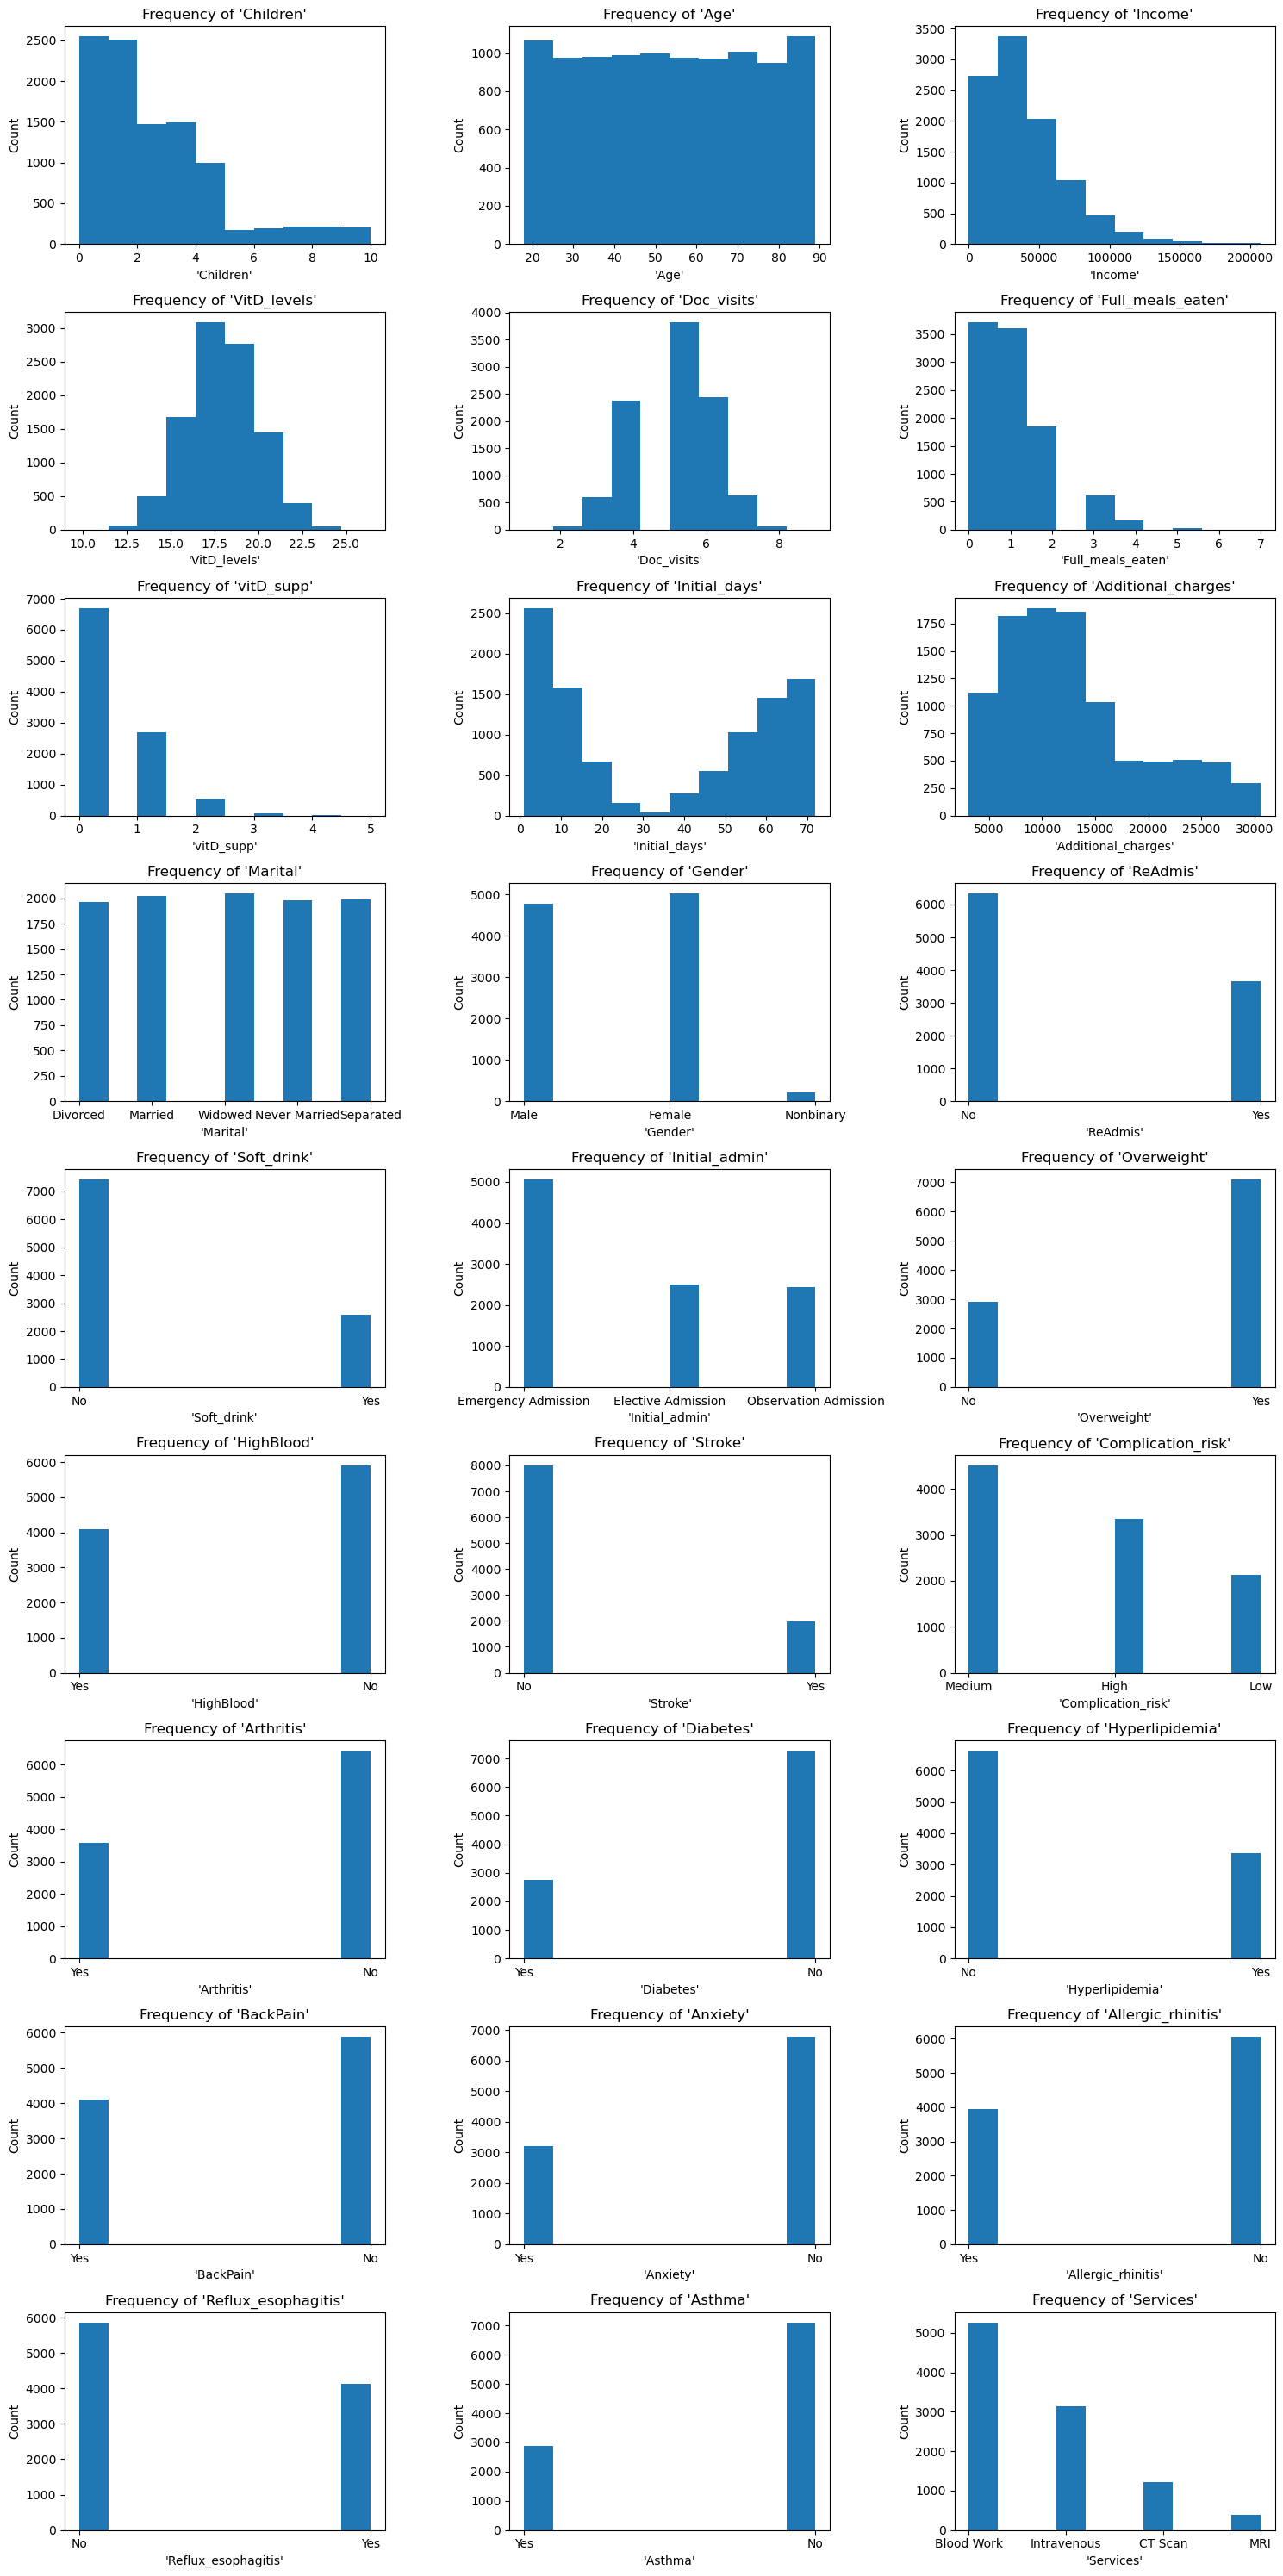

In [9]:
# Univariate Histograms for Independent Variables

num_cols = 3

var_independent = features_continuous + features_categorical

_, axs = plt.subplots(math.ceil(len(var_independent) / num_cols), num_cols, figsize=(15, 30), tight_layout=True)

for i, var in enumerate(var_independent):
    axs[i // num_cols, i % num_cols].hist(data=df, x = var, bins=10)
    name = f'{var=}'.split('=')[1]
    axs[i // num_cols, i % num_cols].set_xlabel(name)
    axs[i // num_cols, i % num_cols].set_ylabel("Count");
    axs[i // num_cols, i % num_cols].set_title(f"Frequency of {name}")

plt.show()

My observations of univariate distirbution visualizations include:

1. Additional_charges has a steep falloff at 15,000
2. Age is evenly distributed. I would have thought there wold have been more elderly getting admitted compared to 20 year olds.

### Bivariate Visualizations

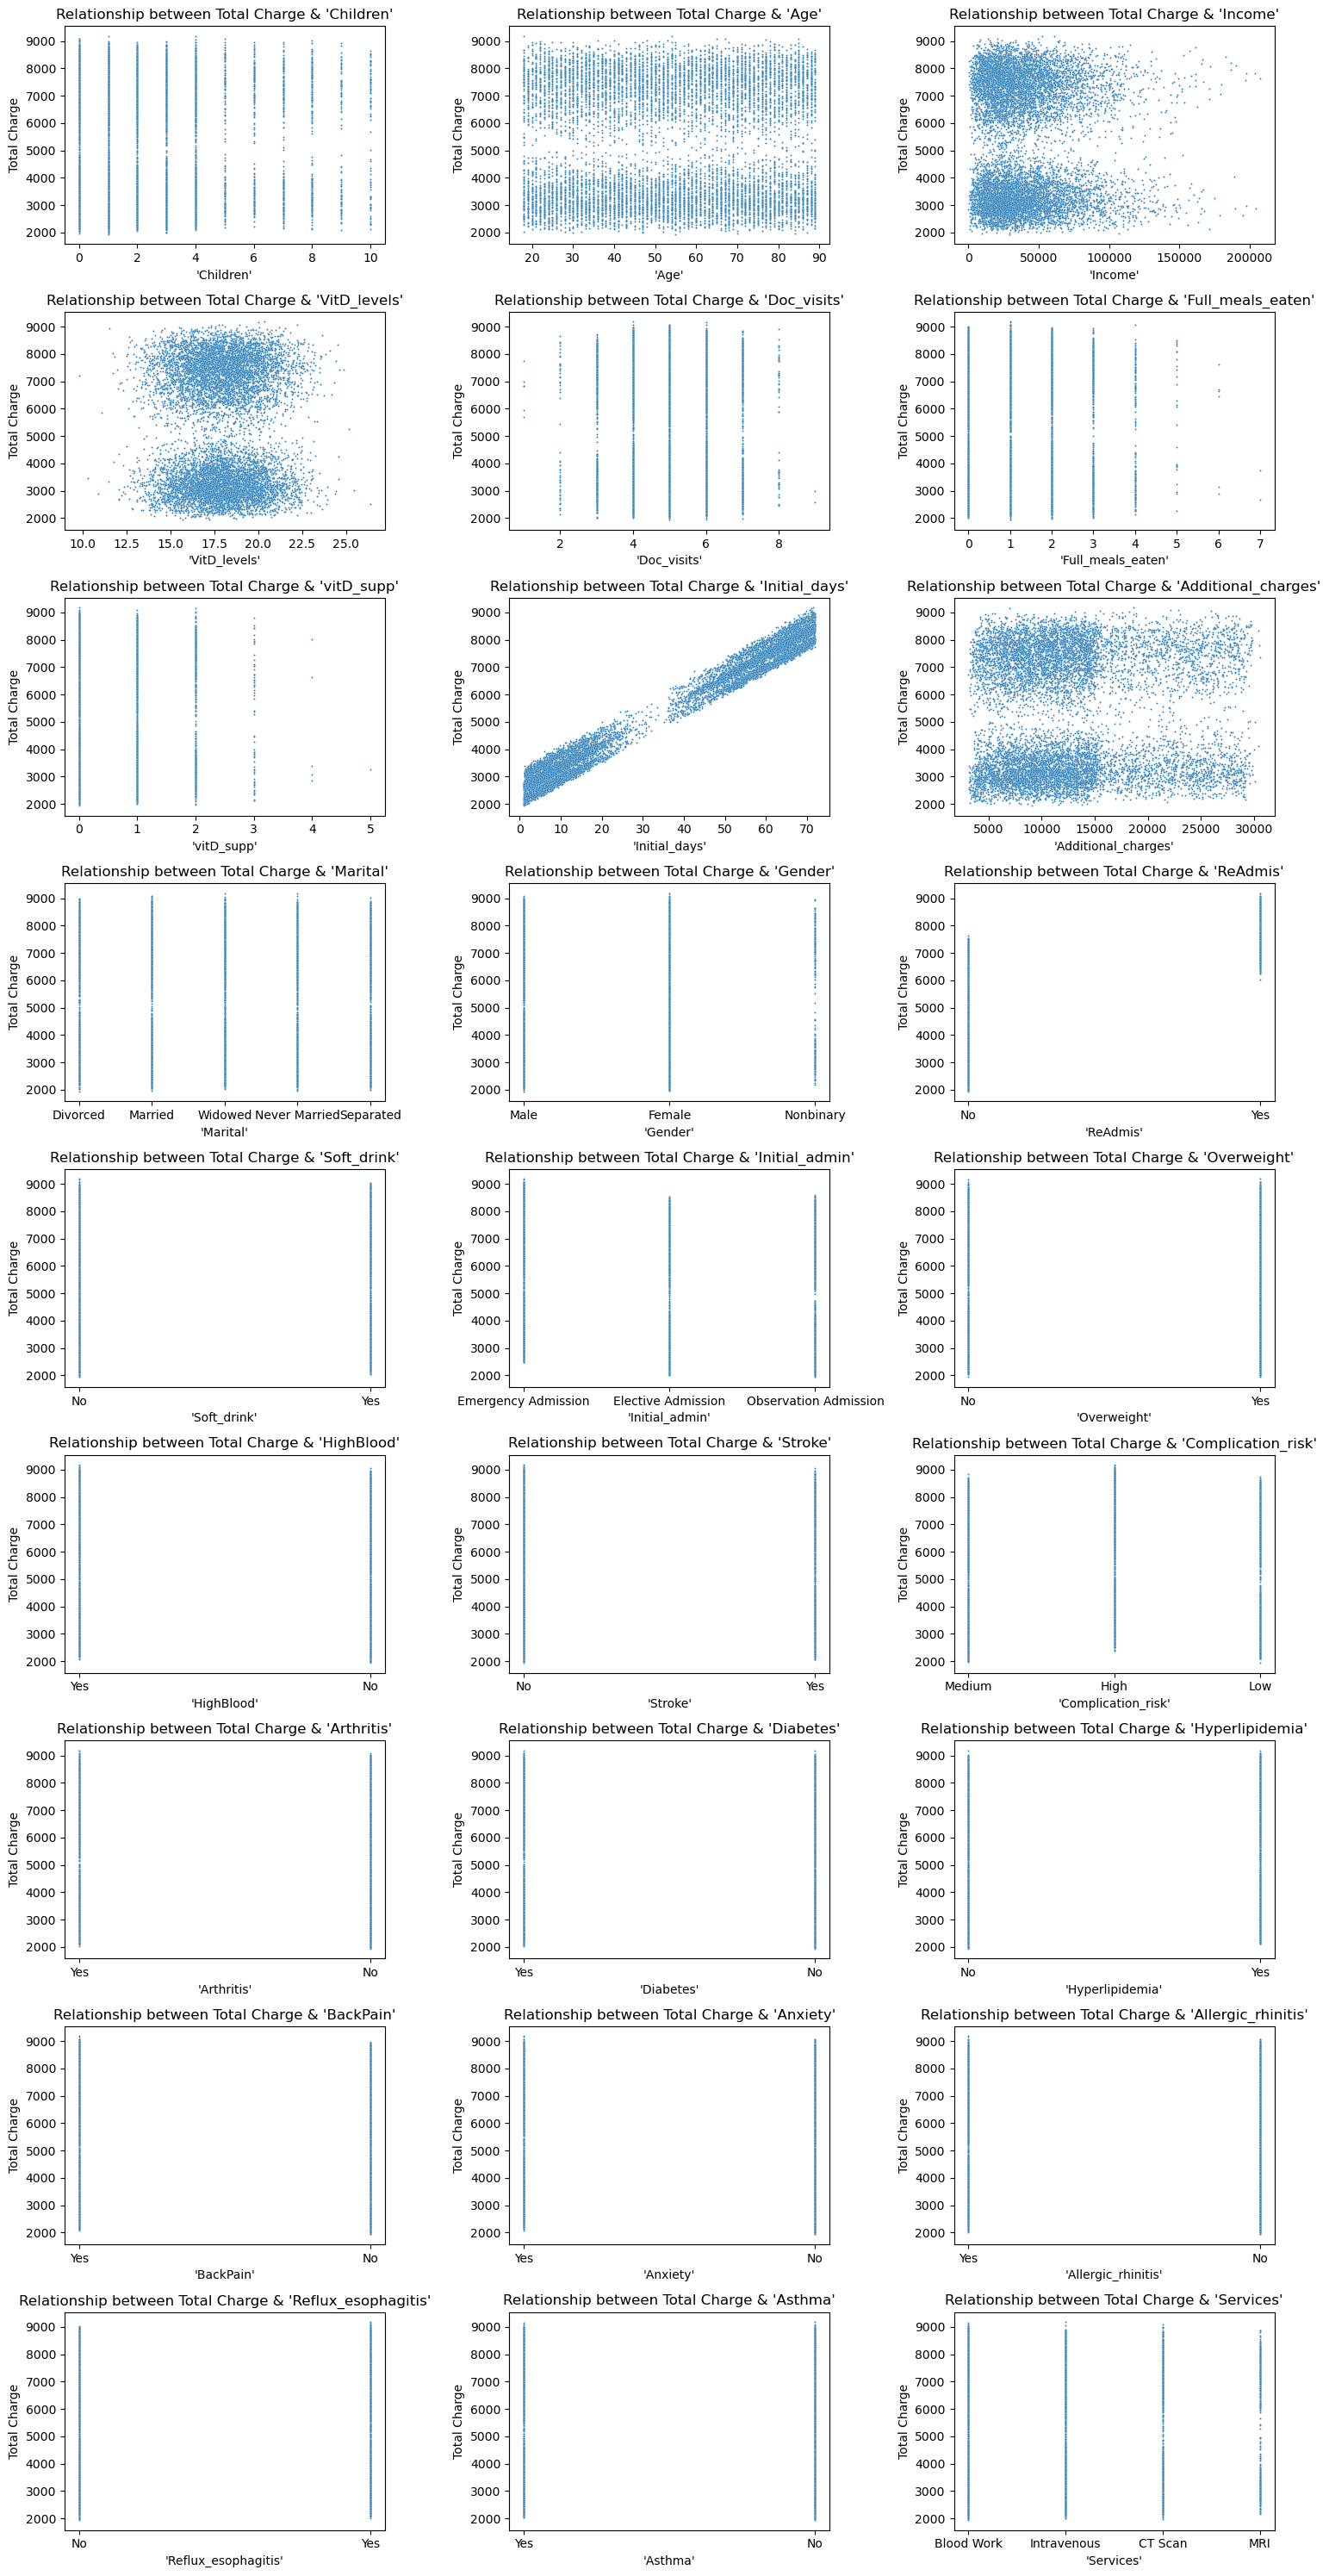

In [10]:
# Bivariate Histograms for each Independent Variables against TotalCharge

num_cols = 3

fig, axs = plt.subplots(math.ceil(len(var_independent) / num_cols), num_cols, figsize=(15, 30), tight_layout=True)

for i, var in enumerate(var_independent):
    sns.scatterplot(data=df, x=var, y='TotalCharge', s=2, ax=axs[i // num_cols, i % num_cols])
    name = f'{var=}'.split('=')[1]
    axs[i // num_cols, i % num_cols].set_xlabel(name)
    axs[i // num_cols, i % num_cols].set_ylabel("Total Charge");
    axs[i // num_cols, i % num_cols].set_title(f"Relationship between Total Charge & {name}")

plt.show()

My observations of bivariate distribution visualizations include:

1. Total Charges and Initial Days are correlated: This is pretty obvious and could have been hypothesized prior. The longer your stay the more it costs.
2. Readmis and  Total Charges are correlated: If you require multiple months of hospitalization you will be charged more.
3. There does not seem to be a correlation between Age and Total Charge. I would have assumed older folks have longer visits to the hospital.

## Data Transformation

The first step to transform our data for our analysis will be to convert features to the correct types:
1. Convert Object Data Types to Categorical for Marital, Gender, Initial_admin, Complication_risk, and services.
2. Convert Boolean Data Types to Integers for ReAdmis, Soft_drink, HighBlood, Stroke, Overweight, Arthritis, Diabetes, Hyperlipidemia, BackPain, Anxiety, Allergic_rhinitis, Reflux_esophagitis, & Asthma.

The next step will be to convert categorical features into separate boolean features and remove unnecessary duplicates. This is completed using dummies and is important since the analysis will require binary values instead of strings. The removal of duplicate features will also avoid multicollinearity, perfect relationships between variables.

In [11]:
# Convert Categorical
var_cat = ['Marital', 'Gender', 'Initial_admin', 'Complication_risk', 'Services']

for var in var_cat:
    df[var] = df[var].astype("category")

# Convert Boolean
var_bool = ['ReAdmis', 'Soft_drink', 'HighBlood', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia',
            'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma']

for var in var_bool:
    df[var] = df[var].replace({
        "Yes": 1,
        "No": 0
    })

var_numeric = ['Children', 'Age', 'Income', 'VitD_levels', 'Doc_visits', 'Full_meals_eaten',
               'vitD_supp', 'Initial_days','Additional_charges']

In [12]:
# Convert String Categorical into Separate Boolean Features

var_cat_dumm = []

for var in var_cat:
    dummies = pd.get_dummies(df[var], prefix=var, drop_first=True).astype(np.int64)
    df.drop(var, axis=1, inplace=True)
    df = pd.concat([df, dummies], axis="columns")
    var_cat_dumm.extend(dummies.columns)

In [13]:
# Combine Names of all independent variables into 1 list
var_independent = var_numeric + var_bool + var_cat_dumm

## CSV Export

In [14]:
# Export Data
df.to_csv('clean.csv', index=False)

# Model Comparison and Analysis

## Initial Multiple Regression Model

In [15]:
y = df['TotalCharge']
X = df[var_independent].assign(const=1)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            TotalCharge   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.978e+16
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:38:49   Log-Likelihood:                 68300.
No. Observations:               10000   AIC:                        -1.365e+05
Df Residuals:                    9964   BIC:                        -1.363e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Ch

## Reduction Justification

The original model had many features that were correlated and ones that provided little explanation for the variance of total charges. To clean up this model the first step was to remove highly correlated features. This is done by getting the variance inflation factor (VIF) of each feature. Features with VIF values greater than 10 are removed from the model. In our case, these were Doc_visits, Additional_charges, and VitD_levels. Next, any features with pvalues greater than our 0.05 alpha value are removed since these are not significant in our model, this is completed in a recursive function similar to the VIF removal. This included Marital_Never Married, Full_meals_eaten, ReAdmis, Marital_Married, Marital_Widowed, Marital_Separated, Children, Services_MRI, Age, Services_Intravenous, Asthma, Stroke, Income, Gender_Nonbinary, Services_CT Scan, vitD_supp, Initial_admin_Observation Admission, Soft_drink, Overweight, and Gender_Male.

The only features left are not heavily correlated with each other, and ones that provide significance to the model. These will be the only ones important for answering our Research Question.

REVISION NOTE: Originally, I had All P-Values removed at once instead of following Backwards Elimination. I have fixed this by creating a recursive function. In this situation, the outcome is the same, so no other code has been altered.

In [16]:
# vif_removal() is a recursive function that will remove features with VIF > 10.
# The VIF check has to be ran after each feature removal, which necessitates the recursive function
def vif_removal():
    # Create Dataframe for VIF Info
    vif_df = pd.DataFrame()
    vif_df["feature"] = df[var_independent].columns
    vif_df["VIF"] = [variance_inflation_factor(df[var_independent].values, i) for i in range(len(df[var_independent].columns))]
    
    # Highest VIF Variable Data
    highest = vif_df.sort_values('VIF').round(2).tail(1)
    highest_vif = int(highest.VIF)
    highest_column = str(list(highest.feature)[0])
    
    if highest_vif > 10:
        print(highest_column, " has a VIF Value of: ", highest_vif, " and will be removed from the dataset.")
        
        # Drop from Dataframe and from variable list, then run function again
        df.drop(highest_column, axis='columns', inplace=True)
        var_independent.remove(highest_column)
        vif_removal()
    else:
        print("All Features with VIF values > 10 Have been removed.")
        return False

# While VIF > 10, remove
remove = True

while remove:
    remove = vif_removal()

Additional_charges  has a VIF Value of:  78  and will be removed from the dataset.
VitD_levels  has a VIF Value of:  33  and will be removed from the dataset.
Doc_visits  has a VIF Value of:  14  and will be removed from the dataset.
All Features with VIF values > 10 Have been removed.


In [17]:
# New Model after VIF Evaluation
y = df['TotalCharge']
X = df[var_independent].assign(const=1)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            TotalCharge   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.164e+16
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:38:52   Log-Likelihood:                 68298.
No. Observations:               10000   AIC:                        -1.365e+05
Df Residuals:                    9967   BIC:                        -1.363e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Ch

In [18]:
# Significant Variables < 0.05 (alpha value)
# Insignificant Variables are dropped from the DataFrame and removed from the list of independent variables

# REVISION CODE HERE:
# p_removal() is a recursive function that will remove features with pvals > 0.05.
# The Pval check has to be ran after each feature removal, which necessitates the recursive function
def p_removal():   
    # New Model after VIF Evaluation
    y = df['TotalCharge']
    X = df[var_independent].assign(const=1)

    model = sm.OLS(y, X)
    results = model.fit()

    pvals = results.pvalues.sort_values()
    highest = pvals.tail(1)
    highest_name = list(highest.index)[0]
    highest_value = highest.values[0]
    
    if highest_value > 0.05:
        print(highest_name, " has a P Value of: ", highest_value.round(2), " and will be removed from the dataset.")
        
        # Drop from Dataframe and from variable list, then run function again
        df.drop(highest_name, axis='columns', inplace=True)
        var_independent.remove(highest_name)
        p_removal()
    else:
        print("All Features with P values > 0.05 Have been removed.")
        return False

# While pval > 0.05, remove
remove = True

while remove:
    remove = p_removal()

Gender_Male  has a P Value of:  0.98  and will be removed from the dataset.
Overweight  has a P Value of:  0.98  and will be removed from the dataset.
Soft_drink  has a P Value of:  0.93  and will be removed from the dataset.
Initial_admin_Observation Admission  has a P Value of:  0.87  and will be removed from the dataset.
vitD_supp  has a P Value of:  0.8  and will be removed from the dataset.
Services_CT Scan  has a P Value of:  0.76  and will be removed from the dataset.
Gender_Nonbinary  has a P Value of:  0.74  and will be removed from the dataset.
Income  has a P Value of:  0.73  and will be removed from the dataset.
Stroke  has a P Value of:  0.72  and will be removed from the dataset.
Asthma  has a P Value of:  0.51  and will be removed from the dataset.
Services_Intravenous  has a P Value of:  0.47  and will be removed from the dataset.
Services_MRI  has a P Value of:  0.48  and will be removed from the dataset.
Age  has a P Value of:  0.43  and will be removed from the datas

## Final Model

In [19]:
# Final Model after Feature Reduction
y = df.TotalCharge
X = df[var_independent].assign(const=1)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            TotalCharge   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.775e+16
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:38:53   Log-Likelihood:                 68293.
No. Observations:               10000   AIC:                        -1.366e+05
Df Residuals:                    9987   BIC:                        -1.365e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Initia

## Model Comparison

For comparing our initial model to our final model, I decided to use the Adjusted R-squared metric. The adjusted R-squared metric works similarly to the standard R-squared metric, but it penalizes additional unnecessary variables. However, upon assessment, all models have an Adjusted R-squared value of 1, which is unhelpful. The initial model should have had a lower value since it had many unnecessary variables. (Alvira)

What I concluded with some trial and error and additional exploratory analysis, is that the Initial_days feature has a high correlation to our TotalCharges dependent variable. When I removed this feature from the OLS Models, the Adjusted R-squared did begin to penalize additional variables, however, this came at the cost of a lower-scoring overall model. The r-squared value sat at 0.732. I believe the Initial_days feature since it is so correlated to the TotalCharge dependent variable, adjusts based on the other independent variables to explain unknown variance. Because of this, I will keep it in the model, however, we will be unable to see the Adjusted R-squared value increasing.

Without the Adjusted r-squared value we still can visualize the correct outcomes, we have a just as accurate model (r-squared value) with 12 features, as our original model with 35. 

## Model Analysis

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


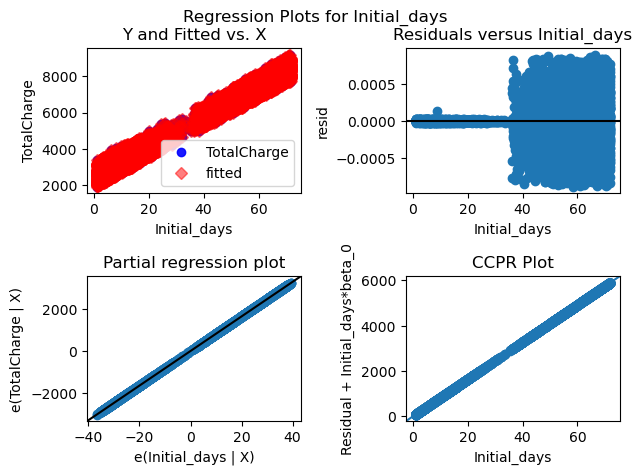

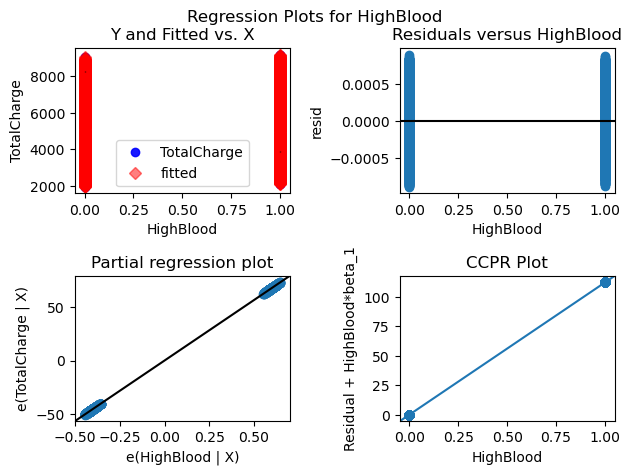

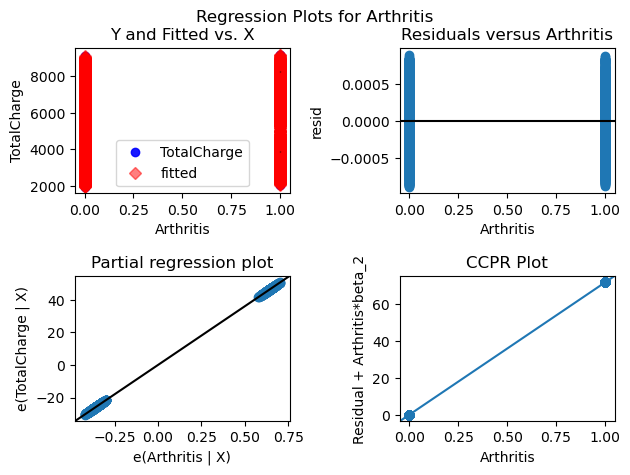

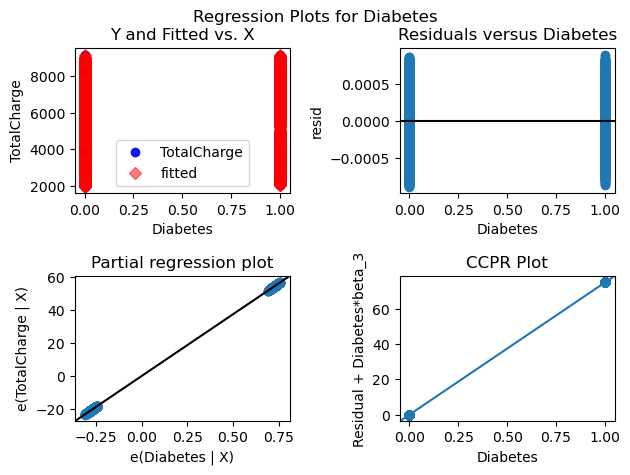

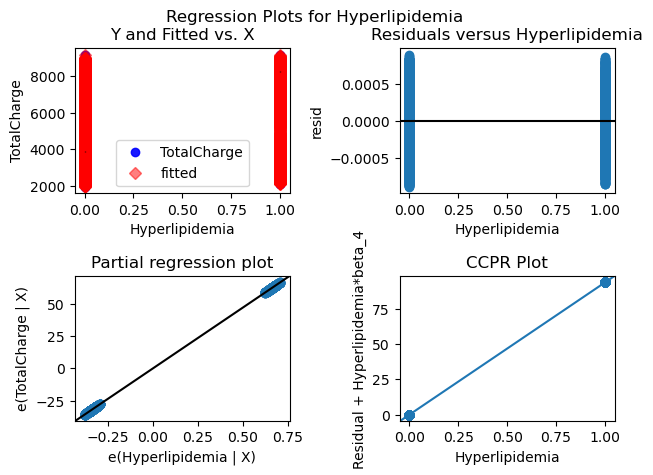

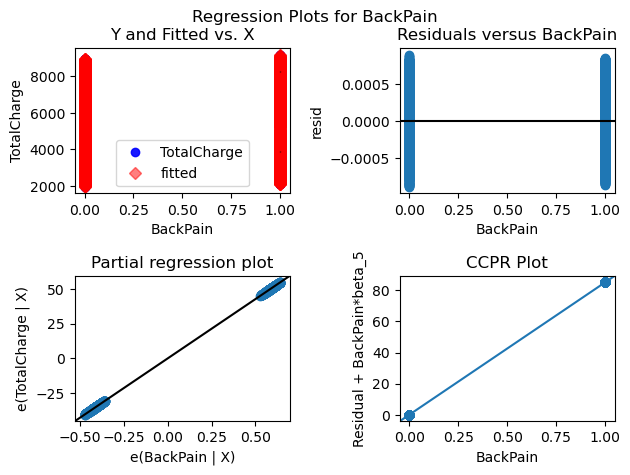

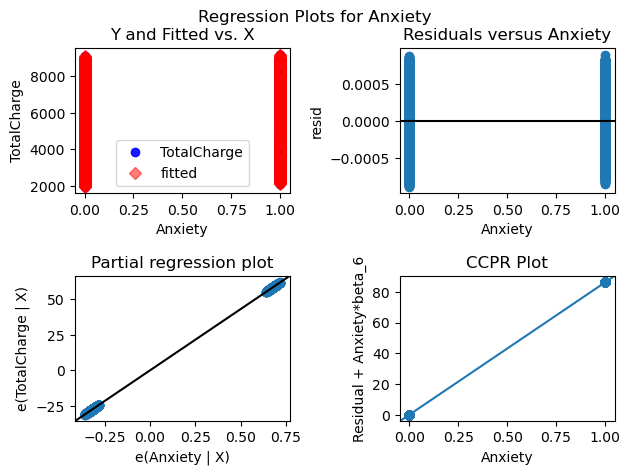

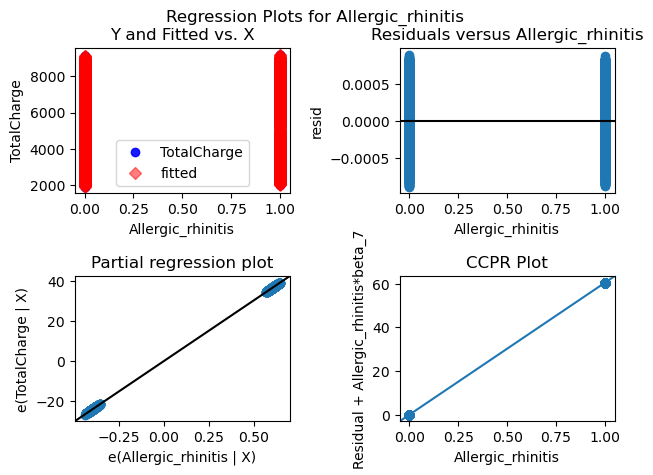

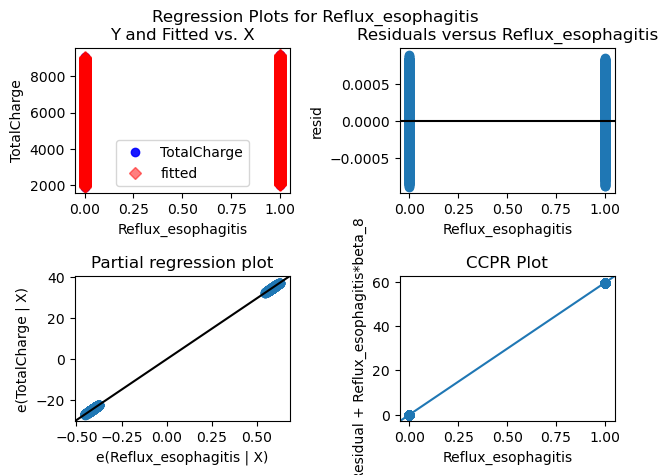

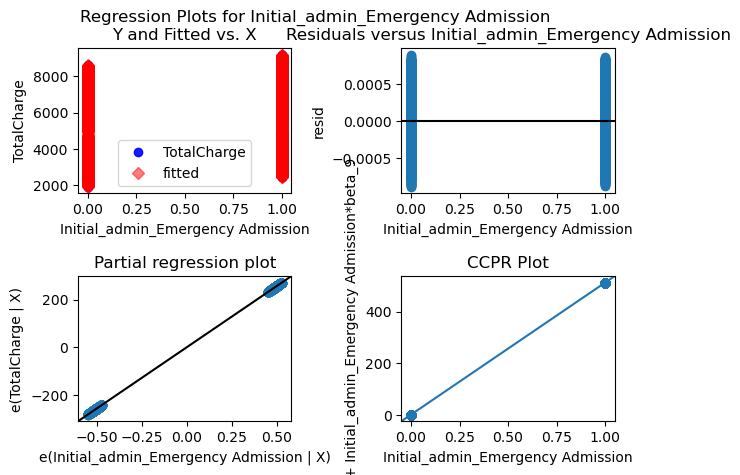

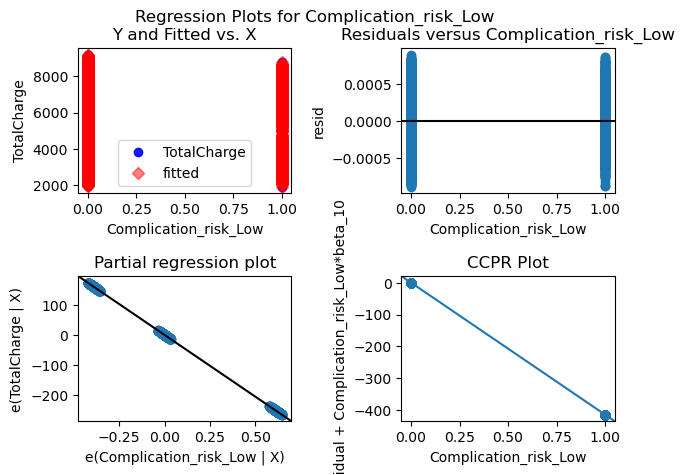

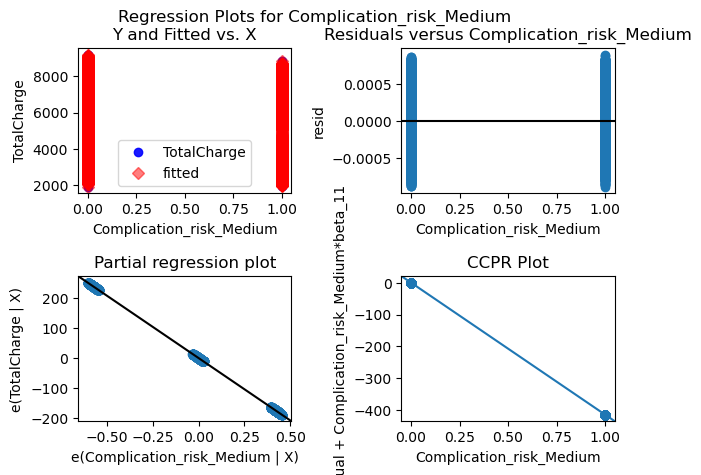

In [20]:
# Residual Plots
for variable in var_independent:
    sm.graphics.plot_regress_exog(results, variable)
plt.show()

In [21]:
print(f"Model Residual Error: {results.resid.std(ddof=df[var_independent].shape[1])}")

Model Residual Error: 0.0002618846334883069


## Executable Code

I am not sure if the above code snippets suffice. If not an additional python file "d208_task1_e3.py" has been included.
To run the file, numpy, pandas, matplotlib, seaborn, and statsmodels libraries have to be installed. That file executes all the above code snippets.

# Part V: Data Summary and Implications

## Results

### Equation

y (TotalCharge) = 2269.18 + 81.94(Initial Days) + 112.32(HighBlood) + 71.95(Arthritis) + 75.20(Diabetes) + 93.99(Hyperlipidemia) + 85.14(BackPain) + 86.11(Anxiety) + 60.58(Allergic_rhinitis) + 59.68(Reflux_esophagitis) + 512.32(Initial_admin_Emergency Admission) - 413.49(Complication_risk_Low) - 413.49(Complication_risk_Medium)

### Practical Interpretation

A Patients total charge can be interpreted as the following:

- All things constant, a patient will be charged 2269.18 by default.

- All things constant, for each day in the hospital a patient will be charged another $ 81.94.

- All things constant, if the patient has high blood pressure, they will be charged another $ 112.32.

- All things constant, if they have arthritis they will be charged an additional $ 71.95.

- All things constant, if they have diabetes they will be charged an additional $ 75.20.

- All things constant, if they have hyperlipidemia they will be charged an additional $ 93.99.

- All things constant, if they have back pain they will be charged an additional $ 85.14.

- All things constant, if they have anxiety they will be charged an additional $ 96.11.

- All things constant, if they have allergic rhinitis they will be charged an additional $ 60.58.

- All things constant, if they have reflux esophagitis they will be charged an additional $ 59.68.

- All things constant, if they were admitted for an emergency they will be charged an additional $ 512.32.

- All things constant, if they have a low complication risk they will remove $ 413.49 from their charges.

- All things constant, if they have a medium complication risk they will remove $ 413.49 from their charges.

### Significance

This model is not only statistically significant but practical as well.
Statistically, our regression results, a Prob (F-statistic) of 0.00, and R-squared of 1.00 show we are accounting for 100% of the variance in the model with the 12 features with p-values under 0.05 (alpha). Practically, we can estimate our total charges through 12 simple questions, which will allow the hospital to assist patients with estimating costs for future visits. From my personal experience working the finances, and dealing with insurance + healthcare, a lot of patients' hesitations and financial fears of healthcare come from not just the large costs, but the unknown costs as well. Having the ability to estimate costs for patients before a visit or before treatment can be very important in patient retention and satisfaction.

### Limitations

1. This model does not take into account social & geographical features, population and area are not included. The location could have a large impact on costs.
2. Some boolean features may be better suited as continuous. For example, High Blood Pressure may provide more information as a continuous variable.
3. Some variables are subjective. One person's High Complication risk may be different from another's. It is not clear if is a standardized feature.

# Recommendations

I believe we should use the model to create a simple cost estimator for patients. This tool would remove financial fears and increase patient retention and satisfaction. I do think it is worth more research to find out if creating geographic/region/area-specific estimators would be more effective. However, I do believe this model is a good start.

# Presentation

https://youtu.be/cAhz5rzJsEM

# Web Sources

Model Building:

Van den Broeck, M. (n.d.). Intro to Regression with statsmodels in Python. Datacamp. Retrieved December 12, 2023, from https://app.datacamp.com/learn/courses/introduction-to-regression-with-statsmodels-in-python

Van den Broeck, M. (n.d.). Intermediate Regression with statsmodels in Python. Datacamp. Retrieved December 12, 2023, from https://app.datacamp.com/learn/courses/intermediate-regression-with-statsmodels-in-python

Vestuto, J. (n.d.). Intro to Linear Modeling in Python. Datacamp. Retrieved December 12, 2023, from https://app.datacamp.com/learn/courses/introduction-to-linear-modeling-in-python

Verbiest, N. (n.d.). Intro to Predictive Analytics in Python. Datacamp. Retrieved December 12, 2023, from https://app.datacamp.com/learn/courses/introduction-to-predictive-analytics-in-python

Python: Intro to MLR / OLS in statmodels.api. (n.d.). www.youtube.com. Retrieved December 8, 2023, from https://www.youtube.com/watch?v=0-fkgpK2knA

Model Evaluation:

Can Adjusted R squared be equal to 1? (n.d.). Cross Validated. Retrieved December 8, 2023, from https://stats.stackexchange.com/questions/390064/can-adjusted-r-squared-be-equal-to-1

Frost, J. (2017, April 5). Check Your Residual Plots to Ensure Trustworthy Regression Results! Statistics by Jim. https://statisticsbyjim.com/regression/check-residual-plots-regression-analysis/

How do I do a regression when one independent variable is highly correlated with a dependent variable? (n.d.). Quora. Retrieved December 8, 2023, from https://www.quora.com/How-do-I-do-a-regression-when-one-independent-variable-is-highly-correlated-with-a-dependent-variable

Mahmood, M. S. (2022, April 24). Simple Explanation of Statsmodel Linear Regression Model Summary. Medium. https://towardsdatascience.com/simple-explanation-of-statsmodel-linear-regression-model-summary-35961919868b

Middleton, K. (n.d.). D208 - Webinar: Getting Started with D208 Part II (October). Panopto. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=09b8fdbb-a374-452b-ba53-af39001ff3f3

VIF and get_Dummies:

Sewell, W. (n.d.). D208 Predictive Modeling Webinar - Episode 1. https://westerngovernorsuniversity-my.sharepoint.com/:p:/g/personal/william_sewell_wgu_edu/ER_vJMbYtxJGpxImpZ0DUQcBoVcORYKanFVKNKFcEXkRow?rtime=_ZkGUN_W2kg

# Sources

Alvira Swalin. (2018, April 7). Choosing the Right Metric for Evaluating Machine Learning Models — Part 1. Medium; USF-Data Science. https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4

Statistics Solutions. (2023). Assumptions of Linear Regression. Statistics Solutions. https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-linear-regression/